## Statistical analysis of the RAPM metric calculated from the 2010-2011 season to the 2016-2015-2016 season. This statistic is used to represent how much a player contributes to outscoring their opponent per 36 minuutes of play time.

### Author: Evan Tsiklidis

In [1]:
#import libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
def plot_scatterplots(highlight,non_highlight,x,y): 
    fs = 10
    plt.figure(figsize=(fs, fs), dpi=80)
    plt.scatter(non_highlight[x], non_highlight[y], c='red',label='League',s=fs*1.5)
    plt.scatter(highlight[x], highlight[y],  c='blue',s=fs*1.5)
    for i in range(highlight.shape[0]):
        plt.annotate(highlight['Name'].tolist()[i],(highlight[x].tolist()[i], highlight[y].tolist()[i]),fontsize=fs*1.5)
    plt.xlabel(x.replace('_', ' '),fontsize=fs*1.5)
    plt.ylabel(y.replace('_', ' '),fontsize=fs*1.5)
    plt.show()  

In [3]:
def construct_non_highlighted(df,highlight):
    players_highlighted = highlight.Name.tolist()
    non_highlight = df[~df['Name'].isin(players_highlighted)]
    return non_highlight

In [4]:
#Normalize on a per pandas coluumn basis.  
def scale_col(df,col): 
    """
    A function that takes a pandas dataframe and column as input and returns a scaled version of the column. 
    The column is rescaled to values between 1 and 2. 
    """
    df['Scaled_' + col] = ((df[col]-df[col].min())/(df[col].max()-df[col].min()) +1) 
    return df

In [5]:
#Load in the dataframe
direct = os.getcwd().replace('/Notebooks','/Data/RAPM_SAL_INFO.csv')
df = pd.read_csv(direct).drop(['Unnamed: 0'],axis=1)
df.columns = ['Name','RAPM_Coefficient','Salary']
df.head()

,Name,RAPM_Coefficient,Salary
0,LeBron James,1.836717,113794900.0
1,Manu Ginobili,1.752981,57383568.0
2,Kyle Korver,1.735350,33760563.0
3,Kevin Durant,1.592873,96379794.0
4,Stephen Curry,1.435763,41877343.0


## We are mainly interested in finding undervalued players, I propose dividing each player's RAPM coefficient by his salary. In theory, players with larger coefficients contribute to winning NBA-level games so players with large coefficients and relatively low salaries are likely undervalued players. These players should be the target of competitive teams hoping to complete a championship-calibur roster, in particular small-market teams. 

## Prior to dividing the coefficient by the salary, I scaled both variables to real numbers between 1 and 2. Scaling removes the dimensions of each variable and allows us to properly relate the two columns to one another while maintaining the relative spread within each variable. In most ML scaling cases, the columns are rescaled between 0 and 1. However, to avoid division by 0 and asymptoticly large values for players with relatively low salaries, we shifted to values between 1 and 2.  

In [6]:
#Let's construct a new column called 'Value' which will simply be the RAPM coefficient divided by the player's salary. 
df = scale_col(df,'RAPM_Coefficient')
df = scale_col(df,'Salary') 
df['Value'] = df['Scaled_RAPM_Coefficient'] / df['Scaled_Salary']
df = df.sort_values(['Value'],ascending=False).reset_index(drop=True)
df.head(20)

,Name,RAPM_Coefficient,Salary,Scaled_RAPM_Coefficient,Scaled_Salary,Value
0,Jae Crowder,1.416322,13651084.5,1.871586,1.084917,1.725096
1,Kyle Korver,1.735350,33760563.0,1.969036,1.211124,1.625793
2,Kelly Olynyk,0.999571,12454560.0,1.744285,1.077408,1.618965
3,Matthew Dellavedova,0.733922,4907876.0,1.663140,1.030045,1.614629
4,Nick Collison,1.291101,27706336.0,1.833336,1.173127,1.562777
5,Isaiah Thomas,0.944906,19872189.6,1.727587,1.123960,1.537053
6,Danny Green,1.012751,22271911.0,1.748311,1.139021,1.534924
7,C.J. Watson,0.846772,17085680.0,1.697611,1.106472,1.534255
8,Derek Fisher,0.690171,12581776.0,1.649776,1.078206,1.530112
9,Roger Mason Jr.,0.487860,6217556.0,1.587977,1.038264,1.529454


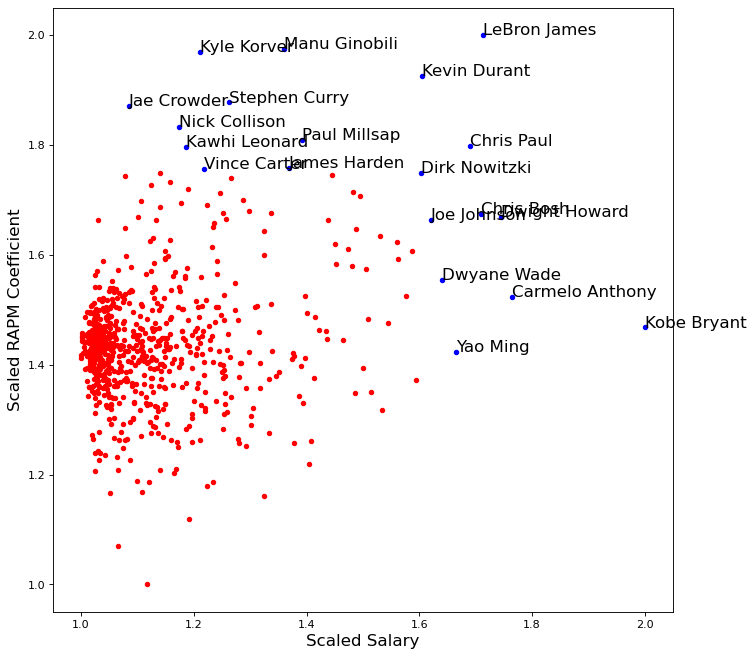

In [7]:
highlight = df[(df['Scaled_Salary'] > 1.6) | (df['Scaled_RAPM_Coefficient'] > 1.75)]
non_highlight = construct_non_highlighted(df,highlight)
plot_scatterplots(highlight,non_highlight,'Scaled_Salary','Scaled_RAPM_Coefficient')

## Ideally we would like to target players in the upper-left quadrant of the scatterplot. These players are likely underpaid relative to the their value and can be a useful addition to a championship contender. 

## Let's start by comparing our new metric with some of the traditional statistics that have been used for the past half-century

In [8]:
#Loop through seasons of data and append them to a pandas dataframe for analysis. 
years = ['2011','2012','2013','2014','2015','2016']
stats = ['Player','G','FG','FGA','3P','3PA','2P','2PA','FT','FTA','ORB','TRB','AST','STL','BLK','TOV','PF','PTS']
all_basic_stats = pd.DataFrame({})
for year in years: 
    direct = os.getcwd().replace('/Notebooks','/Data/')
    temp = pd.read_csv(direct + 'basicstats_' + str(year)+'.csv').drop(['Unnamed: 0'],axis=1)
    all_basic_stats = pd.concat([all_basic_stats,temp])
#Keep the basic stats that we care about. 
all_basic_stats = all_basic_stats[stats]
all_basic_stats.head()

,Player,G,FG,FGA,3P,3PA,2P,2PA,FT,FTA,ORB,TRB,AST,STL,BLK,TOV,PF,PTS
0,Jeff Adrien,23.0,23.0,54.0,0.0,0.0,23.0,54.0,11.0,19.0,23.0,58.0,10.0,4.0,5.0,9.0,28.0,57.0
1,Arron Afflalo,69.0,312.0,627.0,105.0,248.0,207.0,379.0,138.0,163.0,45.0,251.0,168.0,34.0,31.0,71.0,153.0,867.0
2,Maurice Ager,4.0,6.0,11.0,3.0,4.0,3.0,7.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,4.0,4.0,15.0
3,Alexis Ajinça,34.0,59.0,133.0,12.0,34.0,47.0,99.0,13.0,18.0,17.0,78.0,10.0,11.0,19.0,18.0,73.0,143.0
4,Alexis Ajinça,10.0,12.0,32.0,3.0,7.0,9.0,25.0,2.0,3.0,5.0,17.0,2.0,3.0,5.0,1.0,13.0,29.0


In [9]:
#Group players by planername since we have data scattered across multiple seasons. 
all_basic_stats_tot = all_basic_stats.groupby(['Player']).sum().reset_index()
all_basic_stats_tot.head()

,Player,G,FG,FGA,3P,3PA,2P,2PA,FT,FTA,ORB,TRB,AST,STL,BLK,TOV,PF,PTS
0,A.J. Price,231.0,455.0,1227.0,173.0,573.0,282.0,654.0,163.0,228.0,62.0,321.0,507.0,97.0,6.0,184.0,199.0,1246.0
1,Aaron Brooks,519.0,1724.0,4254.0,619.0,1734.0,1105.0,2520.0,688.0,812.0,205.0,863.0,1601.0,316.0,77.0,805.0,1031.0,4755.0
2,Aaron Gordon,125.0,367.0,787.0,55.0,190.0,312.0,597.0,173.0,254.0,200.0,676.0,161.0,80.0,77.0,104.0,236.0,962.0
3,Aaron Gray,206.0,241.0,472.0,0.0,2.0,241.0,470.0,87.0,165.0,274.0,807.0,120.0,60.0,50.0,181.0,436.0,569.0
4,Aaron Harrison,21.0,5.0,19.0,3.0,10.0,2.0,9.0,5.0,12.0,4.0,15.0,2.0,6.0,0.0,4.0,10.0,18.0


In [10]:
#Compute per game stats. 
all_basic_stats_tot['PPG'] = all_basic_stats_tot['PTS'] / all_basic_stats_tot['G']
all_basic_stats_tot['APG'] = all_basic_stats_tot['AST'] / all_basic_stats_tot['G']
all_basic_stats_tot['SPG'] = all_basic_stats_tot['STL'] / all_basic_stats_tot['G']
all_basic_stats_tot['BPG'] = all_basic_stats_tot['BLK'] / all_basic_stats_tot['G']
all_basic_stats_tot['TPG'] = all_basic_stats_tot['TOV'] / all_basic_stats_tot['G']

all_basic_stats_tot['FG%'] = all_basic_stats_tot['FG'] / all_basic_stats_tot['FGA']
all_basic_stats_tot['3P%'] = all_basic_stats_tot['3P'] / all_basic_stats_tot['3PA']
all_basic_stats_tot['EFG'] = (all_basic_stats_tot['FG'] + 0.5*all_basic_stats_tot['3P']) / all_basic_stats_tot['FGA']

In [11]:
df.head()

,Name,RAPM_Coefficient,Salary,Scaled_RAPM_Coefficient,Scaled_Salary,Value
0,Jae Crowder,1.416322,13651084.5,1.871586,1.084917,1.725096
1,Kyle Korver,1.735350,33760563.0,1.969036,1.211124,1.625793
2,Kelly Olynyk,0.999571,12454560.0,1.744285,1.077408,1.618965
3,Matthew Dellavedova,0.733922,4907876.0,1.663140,1.030045,1.614629
4,Nick Collison,1.291101,27706336.0,1.833336,1.173127,1.562777


In [12]:
#Perform a merge with some basic stats.
df = df.merge(all_basic_stats_tot,left_on='Name',right_on='Player',how='inner')
df.head()

,Name,RAPM_Coefficient,Salary,Scaled_RAPM_Coefficient,Scaled_Salary,Value,Player,G,FG,FGA,...,PF,PTS,PPG,APG,SPG,BPG,TPG,FG%,3P%,EFG
0,Jae Crowder,1.416322,13651084.5,1.871586,1.084917,1.725096,Jae Crowder,393.0,1089.0,2566.0,...,700.0,3042.0,7.740458,1.213740,0.997455,0.312977,0.689567,0.424396,0.318182,0.493959
1,Kyle Korver,1.735350,33760563.0,1.969036,1.211124,1.625793,Kyle Korver,447.0,1546.0,3395.0,...,884.0,4520.0,10.111857,2.125280,0.722595,0.387025,1.096197,0.455376,0.448011,0.601325
2,Kelly Olynyk,0.999571,12454560.0,1.744285,1.077408,1.618965,Kelly Olynyk,203.0,738.0,1586.0,...,603.0,1950.0,9.605911,1.591133,0.743842,0.487685,1.369458,0.465322,0.372745,0.523960
3,Matthew Dellavedova,0.733922,4907876.0,1.663140,1.030045,1.614629,Matthew Dellavedova,215.0,440.0,1114.0,...,451.0,1227.0,5.706977,3.386047,0.469767,0.074419,1.102326,0.394973,0.397504,0.495063
4,Nick Collison,1.291101,27706336.0,1.833336,1.173127,1.562777,Nick Collison,421.0,723.0,1342.0,...,1010.0,1759.0,4.178147,1.230404,0.489311,0.375297,0.833729,0.538748,0.238095,0.546200


## Basic stats are meant to measure the effectiveness of a player at essential aspects of the game. We should expect to see some agreement in a statistic like effective field goal percentage since efficient players typically maximize their team's offensive possessions. We would expect this stat to be higher for players that the model calculated to be undervalued than those who are undervalued. 

## Note that effective field goal goal % does not necessarily ALWAYS correlate with outscoring the opposition perfectly. It is perfectly possible for a player to be very efficient on the offensive end but be unable to defend his opponent. It is also possible for the player to be unable to shoot enough shots for their high scoring efficiency to effect the outcome of the game, likely due to some other inefficiency.  

In [13]:
q = df.Scaled_RAPM_Coefficient.quantile(0.95)
high_value = df[df['Scaled_RAPM_Coefficient'] > q]
efh_high = high_value.EFG.mean()
efh_high

0.526233570467706

In [14]:
q = df.Scaled_RAPM_Coefficient.quantile(0.05)
low_value = df[df['Scaled_RAPM_Coefficient'] <q]
efg_low = low_value['EFG'].mean()
efg_low

0.4925048962945576

In [15]:
low_value['EFG'].var()

0.0008932458252670596

In [16]:
high_value['EFG'].var()

0.0011923641035775524

## The mean's of the two groups certainly look different, we should perform an independent 2-sample t-test. The-test is used to quantify whether their is a statistical difference in the mean of 2 independently sampled groups or not. The test returns a p-value, which is the probability that the 2 samples came from the same distribution. If smaller than some prespecified threshold, (e.g., 0.01), then we can reject the hypothesis that they come from the same distribution and conclude that their is a statistical difference between the two groups. 

A t-test can only be valid if the following 4 assumptions are met. 

1. Independence: The samples should have been sampled independent of one another. These samples ultimately orginated by specifiying an aribitrary set of years, so they were effectively randomly sampled. 
2. Homogeneity of variance: Both samples have approximately the same variance. 
3. Sample size: Both groups have an equal number of samples. 

In [17]:
from scipy import stats
stats.ttest_ind(high_value.EFG.tolist(), low_value.EFG.tolist())

Ttest_indResult(statistic=4.36934914243463, pvalue=4.364813351990636e-05)

## The p-value is indeed <0.01 and we can conclude that their is a statistical difference between the two groups. It looks like we are on the right track with our RAPM statistic as we have concluded that players with higher RAPM score more efficiently than players with lower RAPM. Does this hold for players on the lower-end of the salary range? Advanced stats are not needed to conclude that LeBron James can help a championship-contending team, but what about these "role-players"? Which players would be good compliments to LeBron? 

In [18]:
#Let's compare players with high RAPM scores to low RAPM scores, and also who are on the lower-end of the pay scale. 
group_a = df[(df['Scaled_Salary'] < 1.4) & (df['Scaled_RAPM_Coefficient'] > 1.7)]
group_b = df[(df['Scaled_Salary'] < 1.4) & (df['Scaled_RAPM_Coefficient'] < 1.3)]

In [19]:
group_a['EFG'].mean()

0.5359894751770029

In [20]:
group_b['EFG'].mean()

0.4852697609034098

In [21]:
group_a['EFG'].var()

0.0011218245445817393

In [22]:
group_b['EFG'].var()

0.0009746478067934798

In [23]:
group_a.shape

(15, 32)

In [24]:
group_b.shape

(53, 32)

In [25]:
stats.ttest_ind(group_a.EFG.tolist(), group_b.EFG.tolist(),equal_var=False)

Ttest_indResult(statistic=5.254366665801657, pvalue=3.1148474042061803e-05)